### 관련 라이브러리 로드

In [ ]:
# 한국어 폰트를 설치합니다. 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [130]:
import pandas as pd
import numpy as np
import copy
import random 

import matplotlib.pyplot as plt
import seaborn as sns
# 브라우저에서 바로 그려지도록 
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

sns.set_style('whitegrid')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


### Confusion Matrix 소개
Confusion Matrix는 실제 값과 예측 값을 바탕으로 정사각행렬을 구성하여 다양한 분류 모형 평가 지표 계산을 용이하도록 합니다. 일반적으로 다음과 같이 형성됩니다. 

Confusion Matrix를 이용하여 accuracy, recall, precision, f1 score 계산이 간단히 이루어지기 때문에, 아래와 같이 하나의 함수를 통해 구현이 가능합니다. 

In [131]:
def get_metric(prediction, actual) :
    # prediction : 예측값
    # actual : 실제값
    # confusion_matrix : 혼동행렬
    # TP : True Positive
    # TN : True Negative
    # FP : False Positive
    # FN : False Negative
    # accuracy : 정확도
    # precision : 정밀도
    # recall : 재현율
    # f1-score : F1 점수
    # support : 데이터 건수
    confusion_matrix = pd.crosstab(prediction, actual, rownames=['Predicted'], colnames=['Actual'], margins=True)
    accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1]) / (confusion_matrix[0][0] + confusion_matrix[0][1] + confusion_matrix[1][0] + confusion_matrix[1][1])
    precision = confusion_matrix[1][1] / (confusion_matrix[0][1] + confusion_matrix[1][1])
    recall = confusion_matrix[1][1] / (confusion_matrix[1][0] + confusion_matrix[1][1])
    f1_score = 2 * precision * recall / (precision + recall)
    auroc = metrics.roc_auc_score(actual, prediction)
    return confusion_matrix, accuracy, precision, recall, f1_score, auroc

다만, 각 요소의 구동 방식을 이해하기 위해 하나씩 진행해보도록 하겠습니다. 

#### 1-0. 예시 작성
다음과 같은 모델의 예측값과 실제 값이 있다고 하겠습니다.  
이때, 저희가 집중적으로 관찰하고 싶은 예측 범주(공정 상 불량 제품 여부)를 1로 설정하고, 이외 범주(정상 제품)을 0으로 설정하겠습니다. 

In [132]:
prediction = [1, 1, 1, 1, 1, 0, 0, 0, 0, 1]
actual     = [1, 0, 1, 1, 1, 0, 1, 0, 0, 0]

confusion_matrix = pd.crosstab(prediction, actual, rownames=['Predicted'], colnames=['Actual'])
confusion_matrix

Actual,0,1
Predicted,,
0,3,1
1,2,4


#### 1-1. Accuracy 계산

정확도는 아래와 같이 구성되므로 실제 Confusion Matrix의 해당 성분을 이용하여 계산할 수 있습니다.  
$$ accuracy = {(n_{11} + n_{00}) \over (n_{11} + n_{10} + n_{01} + n_{00})} $$

In [133]:
accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1]) / (confusion_matrix[0][0] + confusion_matrix[0][1] + confusion_matrix[1][0] + confusion_matrix[1][1])
accuracy

0.7

#### 1-2. Recall 계산

재현율은 아래와 같이 구성되므로 실제 Confusion Matrix의 해당 성분을 이용하여 계산할 수 있습니다.  
$$ recall = {n_{11} \over (n_{11} + n_{10})}

In [134]:
recall = confusion_matrix[1][1] / (confusion_matrix[1][0] + confusion_matrix[1][1])
recall

0.8

#### 1-3. Precision 계산
정밀도는 아래와 같이 구성되므로 실제 Confustion Matrix의 해당 성분을 이용하여 계산할 수 있습니다. 
$$ precision = {n_{11} \over (n_{11} + n_{01})} $$

In [135]:
precision = confusion_matrix[1][1] / (confusion_matrix[0][1] + confusion_matrix[1][1])
precision

0.6666666666666666

#### 1-4. F1 Score 계산
F1 Score는 아래와 같이 구성되므로 실제 Confusion Matrix에서 계산된 recall과 precision을 이용하여 계산할 수 있습니다.  
$$ F1 Score = {2 \times recall \times precision \over recall + precision} $$

In [136]:
f1_score = 2 * precision * recall / (precision + recall)
f1_score

0.7272727272727272

#### 1-5. AUROC 계산
AUROC는 모델의 예측 확률을 기반으로 계산됩니다. 그러므로 이전까지의 계산과 다르게 모델이 각 데이터에 대해 1일 확률을 예측한 값을 기반으로 아래와 같이 계산될 수 있습니다. 실제 계산 시에는 sklearn 패키지 내의 함수를 이용합니다. 하지만 동작 원리를 파악하기 위해서 1) fpr, tpr 계산 공식 2) 사다리꼴 넓이 계산 공식 3) AUROC 계산 함수를 구현해보겠습니다. 

### 1-5-1. FPR, TPR 계산 함수

FPR은 False Positive Rate으로서 실제로 Negative(1)인 객체들에 대해 모델이 Positive(0)로 예측한 비율을 의미합니다. 공식으로 표현하면 아래와 같습니다. 

$$ FPR = {n_{01} \over (n_{01} + n_{00})} $$

TPR은 True Positive Rate으로서 실제로 Positive인 객체들에 대해 모델이 Positive로 옳바르게 예측한 비율을 의미합니다. 공식으로 표현하면 아래와 같습니다. 

$$ TPR = {n_{11} \over (n_{11} + n_{10})}

In [137]:
## 위 두 공식을 함수로 구현하면 아래와 같습니다. 
def get_TPR(confusion_matrix) :
    # TPR : True Positive Rate
    # TPR : True Positive / (True Positive + False Negative)
    return confusion_matrix[1][1] / (confusion_matrix[1][0] + confusion_matrix[1][1])

def get_FPR(confusion_matrix) :
    # FPR : False Positive Rate
    # FPR : False Positive / (False Positive + True Negative)
    return confusion_matrix[0][1] / (confusion_matrix[0][0] + confusion_matrix[0][1])


### 1-5-2. Threshold 별 TPR, FPR 계산

ROC는 모델이 예측한 확률에 대해 Threhold를 변경하며, 실제 예측값을 결정하면서 TPR과 FPR의 비율 변화를 모두 기록한 것입니다. 이는 1) Threshold를 변경하며 TPR과 FPR 계산 2) TPR과 FPR을 이용하여 Curve의 아래 넓이 계산 두 함수로 구현될 수 있습니다. 

In [138]:
def get_confusion_matrix(prediction, actual) :
    matrix = pd.DataFrame(data = np.zeros((2, 2)), columns = [1, 0], index = [1, 0])
    for i in [1, 0] :
        for j in [1, 0] :
            pred_i = [pred == i for pred in prediction]
            act_j = [act == j for act in actual]
            matrix.loc[i, j] = np.sum([pred_i[k] and act_j[k] for k in range(len(prediction))])
    return matrix

In [139]:
def get_sadari(x_start, x_end, y_small, y_large) :
    """
    AUROC는 사다리꼴 너비의 합으로 계산됩니다. 
    사다리꼴 너비를 구하는 함수입니다. 
    """
    return (y_small + y_large) * (x_end - x_start) / 2

def get_AUROC(prediction, actual) :
    """
    AUROC : Area Under the Receiver Operating Characteristic Curve
    ROC 곡선의 아래 면적을 구하는 함수입니다. 
    """
    # 1. prediction은 확률이므로, prediction을 기준으로 정렬합니다. 

    prediction_sorted, actual_sorted = zip(*sorted(zip(prediction, actual), reverse=True))

    # 2. prediction을 기준으로 정렬된 actual을 기준으로 TPR, FPR을 구합니다.
    TPR_list = []
    FPR_list = []
    for i in range(len(prediction_sorted)) :
        if i != len(prediction_sorted) - 1 :
            if prediction_sorted[i] == prediction_sorted[i+1] :
                continue
        prediction_ = [0]*len(prediction_sorted)
        prediction_[:i+1] = [1]*(i+1)
        confusion_matrix = get_confusion_matrix(prediction_, actual_sorted)
        if confusion_matrix.shape != (2,2) :
            confusion_matrix = pd.DataFrame([[0,0],[0,0]])
        TPR = get_TPR(confusion_matrix)
        FPR = get_FPR(confusion_matrix)
        TPR_list.append(TPR)
        FPR_list.append(FPR)
    
    # 3. TPR, FPR을 기준으로 사다리꼴의 너비를 구합니다.
    AUROC = 0
    for i in range(len(TPR_list) - 1) :
        AUROC += get_sadari(FPR_list[i], FPR_list[i+1], TPR_list[i], TPR_list[i+1])
    return AUROC, TPR_list, FPR_list

/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPytho

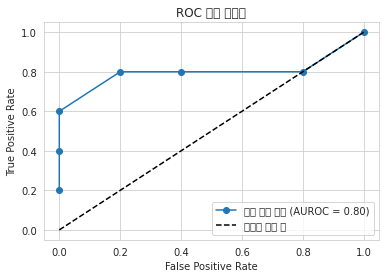

In [140]:
actual     = [1, 0, 1, 1, 1, 0, 1, 0, 0, 0]
prediction = [0.9, 0.6, 0.6, 0.8, 0.7, 0.2, 0.1, 0.3, 0.2, 0.1]
auroc, tpr, fpr = get_AUROC(prediction, actual)
plt.plot(fpr, tpr, 'o-', label="모델 예측 기반 (AUROC = %0.2f)" % auroc)
plt.plot([0, 1], [0, 1], 'k--', label="무작위 예측 시")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC 곡선 시각화')
plt.legend(loc="lower right")
plt.show()

/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.8/site-packages/IPytho

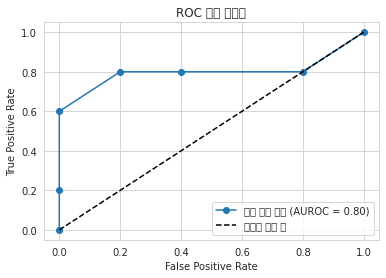

In [141]:
actual     = [1, 0, 1, 1, 1, 0, 1, 0, 0, 0]
prediction = [0.9, 0.6, 0.6, 0.8, 0.7, 0.2, 0.1, 0.3, 0.2, 0.1]

def get_auroc(prediction, actual) :
    # prediction : 예측값
    # actual : 실제값
    # auroc : AUROC 점수
    # fpr : False Positive Rate
    # tpr : True Positive Rate
    # thresholds : 임계값
    # roc_auc : ROC_AUC 점수
    fpr, tpr, thresholds = metrics.roc_curve(actual, prediction)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc, fpr, tpr, thresholds

auroc, fpr, tpr, thresholds = get_auroc(prediction, actual)
## ROC 곡선 그리기
plt.plot(fpr, tpr, 'o-', label="모델 예측 기반 (AUROC = %0.2f)" % auroc)
plt.plot([0, 1], [0, 1], 'k--', label="무작위 예측 시")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC 곡선 시각화')
plt.legend(loc="lower right")
plt.show()

실제로 아래 웹사이트를 통해 AUROC 커브가 생성되는 과정을 자세히 살펴볼 수 있습니다.  
https://arogozhnikov.github.io/2015/10/05/roc-curve.html  
모델이 잘못 예측한 값이 적을수록, TPR과 FPR이 겹치는 영역이 줄어들게 되고, threshold 변화에 따라 trade-off 관계가 적어지게 됩니다.  
결과적으로 이를 통해 아래 그림처럼 ROC 커브 아래의 크기가 커지고, AUROC(Area Under ROC) 값이 커지는 효과를 얻을 수 있습니다. 

![AUROC.git](https://arogozhnikov.github.io/images/roc_curve.gif)

### 2. 데이터 소개

실습 데이터셋은 널리 활용되는 타이타닉 데이터셋입니다. 해당 데이터셋은 실제 타이타닉 호의 승객 데이터를 기반으로 생존 여부를 예측하는 과업을 수행할 수 있습니다. 각 변수에 대한 설명은 다음과 같습니다. 

1. pclass : 해당 승객의 객실 등급
2. age : 해당 승객의 연령
3. sibsp : 해당 승객과 함께 탑승한 형제자매 및 배우자 수 
4. parch : 해당 승객과 함께 탑승한 부모 수 
5. fare : 해당 승객이 타이타닉호 탑승을 위해 지불한 요금
6. survived : 해당 승객의 사고 당시 생존 여부

In [142]:
titanic=sns.load_dataset('titanic')[['pclass', 'age', 'sibsp', 'parch', 'fare', 'survived']]
titanic.head()

,pclass,age,sibsp,parch,fare,survived
0,3,22.0,1,0,7.2500,0
1,1,38.0,1,0,71.2833,1
2,3,26.0,0,0,7.9250,1
3,1,35.0,1,0,53.1000,1
4,3,35.0,0,0,8.0500,0


In [143]:
# 결측치 확인
print(titanic.isnull().sum())
# 결측치 예시 확인
titanic[titanic['age'].isnull()] # 나이가 기록되지 않은 데이터가 있는 것을 확인

pclass        0
age         177
sibsp         0
parch         0
fare          0
survived      0
dtype: int64


,pclass,age,sibsp,parch,fare,survived
5,3,NaN,0,0,8.4583,0
17,2,NaN,0,0,13.0000,1
19,3,NaN,0,0,7.2250,1
26,3,NaN,0,0,7.2250,0
28,3,NaN,0,0,7.8792,1
...,...,...,...,...,...,...
859,3,NaN,0,0,7.2292,0
863,3,NaN,8,2,69.5500,0
868,3,NaN,0,0,9.5000,0
878,3,NaN,0,0,7.8958,0


In [144]:
# 결측치 처리
titanic['age'] = titanic['age'].fillna(titanic['age'].mean()) # 나이가 비어있는 경우 간단하게 전체 승객의 평균 나이로 대체 

In [145]:
X = titanic[['pclass', 'age', 'sibsp', 'parch', 'fare']]
y = titanic['survived']

### 3. 모델 후보군 선정

해당 실습에서 사용할 후보 모델은 다음과 같습니다. 오늘 강의는 각 모델에 대한 이해가 목표가 아니기 때문에 아래와 같이 간략한 설명으로 대체하겠습니다.

In [146]:
logistic_regression = LogisticRegression()
decision_tree = DecisionTreeClassifier()
svm = SVC()

### 4. 데이터 분할
주어진 데이터를 분할하여 학습/평가/테스트 용 데이터를 생성하도록 하겠습니다.  
이때 테스트용 데이터는 실제 서비스 및 공정 적용 상황이라 가정하고, 모델 평가 과정에 반영되지 않습니다. 
모델 개발 시에는 기존에 확보된 데이터를 이용하여 최적의 모델을 학습/선정해야 하기 때문에, 학습 및 평가 데이터를 이용하게 됩니다. 

분류 문제에서 데이터 분할 시 고려해야 하는 점은 데이터 내 실제 label의 분포입니다. 즉, 학습/평가 데이터셋의 분포가 균등하게 추출되지 않았다면, 모델의 성능이 왜곡될 수 있습니다. 이를 고려하여 생존/사망을 균등하게 추출하도록 하겠습니다. 

In [147]:
# stratified sampling
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)

반복적인 학습/평가 데이터 분할 및 평가 진행을 위해 학습/평가 데이터셋 분할 함수를 작성하겠습니다. 

In [148]:
def split_train_val(X_train_and_val, y_train_and_val, val_size = 0.3, seed = 42, stratify = True) :
    """
    다음과 같이 데이터를 분할합니다.
    1. train : 전체 데이터의 49%
    2. validation : 전체 데이터의 21%
    3. 사용하지 않는 데이터 : 전체 데이터의 30% (데이터 분포 실험을 위해 사용하지 않는 데이터를 따로 둡니다.)
    """
    if stratify == True : 
        X_use, X_notuse, y_use, y_notuse = train_test_split(X_train_and_val, y_train_and_val, test_size=val_size, stratify=y_train_and_val, random_state=seed)
        X_train, X_val, y_train, y_val = train_test_split(X_use, y_use, test_size=val_size, stratify=y_use, random_state=seed)
    else :
        # 데이터를 imbalance하게 분할하는 경우 startify를 [0번 클래스 비율 : 1번 클래스 비율]로 설정
        len_0 = len(y_train_and_val[y_train_and_val == 0])
        len_1 = len(y_train_and_val[y_train_and_val == 1])
        total_len = len(y_train_and_val)

        class_0_size = total_len*0.49*stratify[0] # 학습 데이터의 stratiy 비율에 맞게 0번 클래스의 데이터를 분할
        class_1_size = total_len*0.49*stratify[1] # 학습 데이터의 stratiy 비율에 맞게 1번 클래스의 데이터를 분할

        X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=0.16, random_state=seed) # 전체 데이터의 16%를 validation 데이터로 사용

        train_0 = [(X, y) for X, y in zip(X_train.iterrows(), y_train) if y == 0]
        train_1 = [(X, y) for X, y in zip(X_train.iterrows(), y_train) if y == 1]

        train_0 = random.sample(train_0, int(class_0_size))
        train_1 = random.sample(train_1, int(class_1_size))

        X_train, y_train = zip(*(train_0 + train_1))
        X_train = pd.DataFrame([row[1] for row in X_train])

    return X_train, X_val, y_train, y_val


### 5. 학습 및 평가

In [149]:
def train_val_model(model, X_train, y_train, X_val, y_val) :
    # 주어진 학습/평가 데이터를 이용하여 모델을 훈련 및 평가하는 함수입니다.
    model_trained = copy.deepcopy(model)
    model_trained.fit(X_train, y_train) # 학습 데이터를 이용하여 모델을 훈련합니다. 
    prediction = model_trained.predict(X_val) # 훈련된 모델을 검증 데이터에 적용하여 예측값을 구합니다.
    confusion_matrix, accuracy, precision, recall, f1_score, auroc= get_metric(prediction, y_val) # 예측값과 검증 데이터의 평가지표를 구합니다.
    return confusion_matrix, accuracy, precision, recall, f1_score, auroc

In [150]:
def evaluate_model(model, X_train_and_val, y_train_and_val, stratify = True) :
    # 주어진 전체 데이터를 이용하여 모델을 훈련하고, 전체 데이터에 대한 평가지표를 구하는 함수입니다. 
    acc_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    auroc_list = []

    for seed in range(10) :
        X_train, X_val, y_train, y_val = split_train_val(X_train_and_val, y_train_and_val, val_size = 0.2, seed = seed, stratify = stratify)
        confusion_matrix, accuracy, precision, recall, f1_score, auroc = train_val_model(model, X_train, y_train, X_val, y_val)
        acc_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1_score)
        auroc_list.append(auroc)
        print(f'SEED : {seed:<2}, ACCURACY : {accuracy:.4f}, PRECISION : {precision:.4f}, RECALL : {recall:.4f}, F1 : {f1_score:.4f}, AUROC : {auroc:.4f}')
    print('---------------------------------------------------------------------')
    return {'mean_performance' : {'accuracy' : np.mean(acc_list), 'precision' : np.mean(precision_list), 'recall' : np.mean(recall_list), 'f1' : np.mean(f1_list), 'auroc' : np.mean(auroc_list)}, 
            'performance_list' : {'accuracy' : acc_list, 'precision' : precision_list, 'recall' : recall_list, 'f1' : f1_list, 'auroc' : auroc_list}}

### 6. 후보 모델 평가 
위에서 작성된 함수들을 바탕으로 실제 평가를 수행해보겠습니다. 

In [151]:
result_df = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1_score', 'auroc'])

logistic_regression_performance = evaluate_model(logistic_regression, X_train_and_val, y_train_and_val)
result_df.loc[0] = ['logistic_regression'] + list(logistic_regression_performance['mean_performance'].values())

decision_tree_performance = evaluate_model(decision_tree, X_train_and_val, y_train_and_val)
result_df.loc[1] = ['decision_tree'] + list(decision_tree_performance['mean_performance'].values())

svm_performance = evaluate_model(svm, X_train_and_val, y_train_and_val)
result_df.loc[2] = ['svm'] + list(svm_performance['mean_performance'].values())

result_df


SEED : 0 , ACCURACY : 0.7193, PRECISION : 0.6875, RECALL : 0.5000, F1 : 0.5789, AUROC : 0.6786
SEED : 1 , ACCURACY : 0.6754, PRECISION : 0.6000, RECALL : 0.4773, F1 : 0.5316, AUROC : 0.6386
SEED : 2 , ACCURACY : 0.7368, PRECISION : 0.7692, RECALL : 0.4545, F1 : 0.5714, AUROC : 0.6844
SEED : 3 , ACCURACY : 0.7105, PRECISION : 0.6667, RECALL : 0.5000, F1 : 0.5714, AUROC : 0.6714
SEED : 4 , ACCURACY : 0.6316, PRECISION : 0.5312, RECALL : 0.3864, F1 : 0.4474, AUROC : 0.5860
SEED : 5 , ACCURACY : 0.6842, PRECISION : 0.6111, RECALL : 0.5000, F1 : 0.5500, AUROC : 0.6500
SEED : 6 , ACCURACY : 0.6754, PRECISION : 0.5946, RECALL : 0.5000, F1 : 0.5432, AUROC : 0.6429
SEED : 7 , ACCURACY : 0.7018, PRECISION : 0.6389, RECALL : 0.5227, F1 : 0.5750, AUROC : 0.6685
SEED : 8 , ACCURACY : 0.7719, PRECISION : 0.8214, RECALL : 0.5227, F1 : 0.6389, AUROC : 0.7256
SEED : 9 , ACCURACY : 0.7456, PRECISION : 0.7586, RECALL : 0.5000, F1 : 0.6027, AUROC : 0.7000
--------------------------------------------------

,model,accuracy,precision,recall,f1_score,auroc
0,logistic_regression,0.705263,0.667929,0.486364,0.561066,0.664610
1,decision_tree,0.647368,0.545869,0.504545,0.523976,0.620844
2,svm,0.678070,0.688086,0.325000,0.436454,0.612500


### 6-1. 학습 데이터 분포별 성능 평가
위 실험은 학습 데이터의 분포를 고려하지 않고, 단순 성능만 측정한 결과입니다.  
하지만 학습 데이터는 특정 클래스가 더 많은 불균형(imbalance) 상황입니다.  

In [152]:
print(f"전체 학습 데이터 클래스 분포 : \n{y_train_and_val.value_counts()}\n")
print(f"전체 검증 데이터 클래스 분포 : \n{y_test.value_counts()}\n")

전체 학습 데이터 클래스 분포 : 
0    439
1    273
Name: survived, dtype: int64

전체 검증 데이터 클래스 분포 : 
0    110
1     69
Name: survived, dtype: int64



하지만, 실제로는 학습 클래스 내 데이터 분포에 따라 성능이 변화하게 됩니다. 자세한 내용은 향후 강의에서 다뤄질 예정이므로, 학습 데이터 클래스 분포에 따른 지표별 변화만 살펴보겠습니다. 

In [153]:
result_df = pd.DataFrame(columns=['1번 클래스 비율', 'accuracy', 'precision', 'recall', 'f1_score', 'auroc'])

for idx, class_1_ratio in enumerate([0.5, 0.4, 0.3, 0.2]) :
    print(f'============================== {idx+1}번째 실험 ==============================')
    class_0_ratio = 1 - class_1_ratio
    logistic_regression_performance = evaluate_model(logistic_regression, X_train_and_val, y_train_and_val, stratify = [class_0_ratio, class_1_ratio])
    result_df.loc[idx] = [class_1_ratio] + list(logistic_regression_performance['mean_performance'].values())


============================== 1번째 실험 ==============================
SEED : 0 , ACCURACY : 0.7456, PRECISION : 0.6957, RECALL : 0.6809, F1 : 0.6882, AUROC : 0.7359
SEED : 1 , ACCURACY : 0.7193, PRECISION : 0.6579, RECALL : 0.5682, F1 : 0.6098, AUROC : 0.6912
SEED : 2 , ACCURACY : 0.7018, PRECISION : 0.5526, RECALL : 0.5526, F1 : 0.5526, AUROC : 0.6645
SEED : 3 , ACCURACY : 0.6228, PRECISION : 0.4884, RECALL : 0.5000, F1 : 0.4941, AUROC : 0.5972
SEED : 4 , ACCURACY : 0.6404, PRECISION : 0.4694, RECALL : 0.6053, F1 : 0.5287, AUROC : 0.6316
SEED : 5 , ACCURACY : 0.7544, PRECISION : 0.6744, RECALL : 0.6744, F1 : 0.6744, AUROC : 0.7386
SEED : 6 , ACCURACY : 0.7105, PRECISION : 0.6400, RECALL : 0.6809, F1 : 0.6598, AUROC : 0.7061
SEED : 7 , ACCURACY : 0.6404, PRECISION : 0.5116, RECALL : 0.5238, F1 : 0.5176, AUROC : 0.6161
SEED : 8 , ACCURACY : 0.7544, PRECISION : 0.5849, RECALL : 0.8378, F1 : 0.6889, AUROC : 0.7761
SEED : 9 , ACCURACY : 0.6754, PRECISION : 0.4773, RECALL : 0.6000, F1 : 0.53

학습/평가 데이터의 크기를 동일하게 유지한 채, 학습 데이터에서 클래스의 비율만 변경하여 실험을 진행하면, 다음과 같은 결과를 얻을 수 있습니다.  
정확도는 큰 변화가 없지만, precision, recall, f1_score, auroc 측면에서는 뚜렷한 양상을 보이고 있습니다.  
학습 데이터에서 1번 클래스의 수가 줄어들 수록, precision은 증가하고, recall과 f1_score, auroc는 감소하는 모습을 보이고 있습니다. 

In [154]:
result_df

,1번 클래스 비율,accuracy,precision,recall,f1_score,auroc
0,0.5,0.696491,0.575216,0.622384,0.594581,0.681174
1,0.4,0.716667,0.647552,0.478118,0.543595,0.666291
2,0.3,0.706140,0.710197,0.327545,0.443508,0.625831
3,0.2,0.685088,0.787028,0.183589,0.288952,0.578057


이러한 경향은 Confusion Matrix를 통해 더욱 분명하게 확인할 수 있습니다.  
최종 모델을 훈련하면서 다시 확인해보겠습니다. 

### 7. 최종 모델 훈련 및 성능 측정
최종적으로 accuracy, precision 기준으로는 logistic regression의 성능이 우수해 보이나, recall 및 f1 score 기준으로는 decision tree의 성능이 우수한 상황입니다.  
이때 생존자를 찾아내는 것이 중요하다고 판단한다면, Recall이 더 중요한 지표가 될 수 있습니다. 이에 따라 logistic regression을 최종 모델로 선택하겠습니다.   

이제 최종 모델에 대한 test 성능을 측정해보겠습니다. 

In [157]:
confusion_matrix, accuracy, precision, recall, f1_score, auroc = train_val_model(logistic_regression, X_train_and_val, y_train_and_val, X_test, y_test)

In [158]:
print(f'ACCURACY : {accuracy:.4f}\nPRECISION : {precision:.4f}\nRECALL : {recall:.4f}\nF1 SCORE : {f1_score:.4f}\nAUROC : {auroc:.4f}')

ACCURACY : 0.6983
PRECISION : 0.6596
RECALL : 0.4493
F1 SCORE : 0.5345
AUROC : 0.6519


최종 학습 데이터의 크기를 조절하면서, 다시 최종 성능을 도출해보도록 하겠습니다. 

In [174]:
result_df = pd.DataFrame(columns=['1번 클래스 비율', 'accuracy', 'precision', 'recall', 'f1_score', 'auroc'])
for idx, class_1_ratio in enumerate([0.5, 0.4, 0.3, 0.2]) :
    print(f'============================== 학습 데이터 내 생존 클래스 비율 : {class_1_ratio} ==============================')
    class_0_ratio = 1 - class_1_ratio
    train_X, _, train_y, _ = split_train_val(X_train_and_val, y_train_and_val, val_size = 0.3, seed = 42, stratify = [class_0_ratio, class_1_ratio]) 
    confusion_matrix, accuracy, precision, recall, f1_score, auroc = train_val_model(logistic_regression, train_X, train_y, X_test, y_test)
    result_df.loc[idx] = [class_1_ratio] + [accuracy, precision, recall, f1_score, auroc]
    print(confusion_matrix)

============================== 학습 데이터 내 생존 클래스 비율 : 0.5 ==============================
Actual       0   1  All
Predicted              
0           77  30  107
1           33  39   72
All        110  69  179
============================== 학습 데이터 내 생존 클래스 비율 : 0.4 ==============================
Actual       0   1  All
Predicted              
0           83  36  119
1           27  33   60
All        110  69  179
============================== 학습 데이터 내 생존 클래스 비율 : 0.3 ==============================
Actual       0   1  All
Predicted              
0           99  43  142
1           11  26   37
All        110  69  179
============================== 학습 데이터 내 생존 클래스 비율 : 0.2 ==============================
Actual       0   1  All
Predicted              
0          104  48  152
1            6  21   27
All        110  69  179


In [175]:
result_df

,1번 클래스 비율,accuracy,precision,recall,f1_score,auroc
0,0.5,0.648045,0.541667,0.565217,0.553191,0.632609
1,0.4,0.648045,0.550000,0.478261,0.511628,0.616403
2,0.3,0.698324,0.702703,0.376812,0.490566,0.638406
3,0.2,0.698324,0.777778,0.304348,0.437500,0.624901


정확도만 본다면, 0번 클래스와 1번 클래스 비율이 8:2인 경우가 가장 성능이 좋아보입니다.  
하지만, Confusion Matrix를 살펴보거나, recall, f1_score, auroc 등을 살펴보면, 두 클래스가 균등하게 1:1로 학습된 경우 가장 성능이 좋은 모습을 확인할 수 있습니다.  
그 원인은 모델이 불균형한 데이터에 학습되거나, 평가 데이터가 불균형할 경우 Accuracy에서 왜곡이 발생하기 때문입니다. 위 경우에 있어서도, test 데이터에 0번 클래스 데이터가 훨씬 많기 때문에 0번 클래스만 잘 예측한다면 accuracy가 올라가게 됩니다.  
하지만 실제 적용 시에는 수행하는 업무(이상치 탐지 등) 및 확보된 데이터 상황에 따라, 잘 맞추어야 하는 클래스가 특정될 수 있습니다. 

이와 같이 학습된 모델의 성능 평가 시에는 단순하게 하나의 지표로 살펴볼 것이 아니라, 다양한 지표를 활용해 종합적으로 판단할 필요가 있습니다. 